# A Machine learning problem: reduced order modelling and video prediction
Data: 48 videos are available, describing the evolution of a physical field with different initial conditions. Each video is of dimension 128 * 128 * 16 (timesteps) with binary pixel values. For all the tasks please use the first 40 videos as training (including validation) data and the rest 8 as test data

##### Q1 Perform the Principle component analysis of the training dataset where each snapshot (i.e., image) is considered as a sample. Use the principle component for data compressing and decompressing.

1. Convert mp4 to frame png files
2. Perform PCA to compress data



##### Step 1: Import libraries and visualise data

In [1]:
import cv2
import os
from sklearn.decomposition import PCA 
import numpy as np 
import imageio
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import random

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)


In [2]:
videos = np.zeros((49, 16, 128, 128))


for i in range(49):
    path = 'data/video_' + str(i)
    
    if not os.path.exists(path):
        os.mkdir(path)
    else:
        print("Folder already exists")

    vid = cv2.VideoCapture('videos/fire_Chimney_video_' + str(i) + '.mp4')
    print(int(vid.get(cv2.CAP_PROP_FRAME_COUNT)))


    frames = np.zeros((16, 128, 128))

    currentframe = 0

    for j in range(16):

        ret, frame = vid.read()

        if ret == False:
            vid.release()
            print(str(j) + " fail")
            break


        else:
            name = 'data/video_' + str(i) + '/' + str(j) +  ".png"
            g_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            cv2.imwrite(name, g_frame)
            frames[j,:,:] = np.array(g_frame)


            print(str(j) + " success")

        cv2.destroyAllWindows()

    videos[i,:,:,:] = frames


print(videos.shape)


Folder already exists
16
0 success
1 success
2 success
3 success
4 success
5 success
6 success
7 success
8 success
9 success
10 success
11 success
12 success
13 success
14 success
15 success
Folder already exists
16
0 success
1 success
2 success
3 success
4 success
5 success
6 success
7 success
8 success
9 success
10 success
11 success
12 success
13 success
14 success
15 success
Folder already exists
16
0 success
1 success
2 success
3 success
4 success
5 success
6 success
7 success
8 success
9 success
10 success
11 success
12 success
13 success
14 success
15 success
Folder already exists
16
0 success
1 success
2 success
3 success
4 success
5 success
6 success
7 success
8 success
9 success
10 success
11 success
12 success
13 success
14 success
15 success
Folder already exists
16
0 success
1 success
2 success
3 success
4 success
5 success
6 success
7 success
8 success
9 success
10 success
11 success
12 success
13 success
14 success
15 success
Folder already exists
16
0 success
1 success


#### Video 1 pre-PCA

(16, 128, 128)


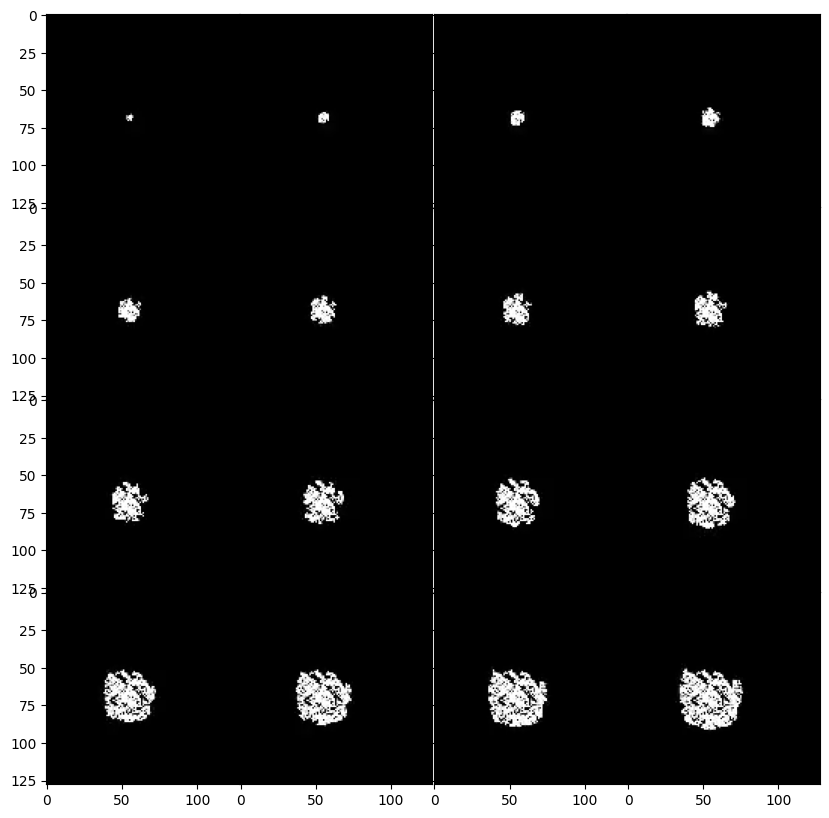

In [3]:
video_0 = videos[0,:,:,:]

video_0.reshape((128, 128, 16))
print(video_0.shape)

def display_frames(video):
    fig, axs = plt.subplots(4, 4, sharey = True, sharex = True, figsize = (10,10))
    fig.subplots_adjust(wspace = 0, hspace = 0)


    for i in range(4):
        axs[i][0].imshow((video[(4*i),:,:]), cmap = 'grey')
        axs[i][1].imshow((video[4*(i)+1,:,:]), cmap = 'grey')
        axs[i][2].imshow((video[4*(i)+2,:,:]), cmap = 'grey')
        axs[i][3].imshow((video[4*(i)+3,:,:]), cmap = 'grey')
        
display_frames(video_0)

#### PCA on video 1

(16, 16384)
(16, 12)
(16, 128, 128)
0.0


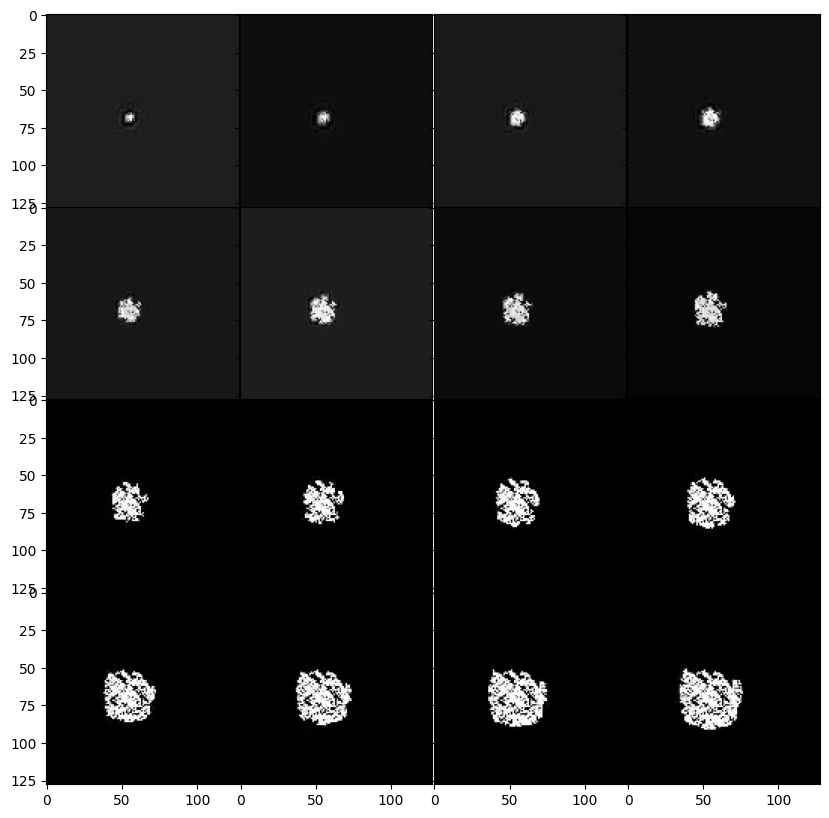

In [4]:
def vid_pca(video, n_components = 16):
    no_frames, height, width = video.shape
    vid_matrix = video.reshape(no_frames,-1)

    print(vid_matrix.shape)


    pca = PCA(n_components= n_components)
    comp = pca.fit_transform(vid_matrix)

    print(comp.shape)

    decomp = pca.inverse_transform(comp)
    decomp = decomp.reshape(no_frames, height, width)

    print(decomp.shape)

    return decomp

vid_0 = vid_pca(video_0, 12)

display_frames(vid_0)

print(video_0[15, 1, 1])



#### TODO:
-	For a random video in the dataset: display the frames before PCA, PCA with 1,4,8,12 and 16 components
- Image compression using convolutional autoencoder
- perform thresholding for binary pixel values

In [5]:
print(torch.__version__)

2.2.1+cu118


In [115]:
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        
        n = 8
        self.encoder = nn.Sequential(
            
            nn.Conv3d(1 ,n, kernel_size= 3, padding =1), 
            nn.BatchNorm3d(n),
            nn.ReLU(),

            nn.Conv3d(n ,2*n, kernel_size= 3,stride =2, padding =1),            
            nn.BatchNorm3d(2*n),
            nn.ReLU(),

            nn.Conv3d(2*n ,4*n, kernel_size= 3,stride =2, padding =1),            
            nn.BatchNorm3d(4*n),
            nn.ReLU(),
            nn.Flatten(),

            
            

        )

        # self.fc = nn.Sequential()

        self.decoder = nn.Sequential(
            
            nn.Unflatten(1, (32, 4, 32, 32)),
            nn.ConvTranspose3d(4*n, 2*n, kernel_size=3, stride =2 ,padding = 1, output_padding=1),
            nn.BatchNorm3d(2*n),
            nn.ReLU(),
            
            nn.ConvTranspose3d(2*n,2*n,kernel_size=3, padding= 1),
            nn.BatchNorm3d(2*n),
            nn.ReLU(),
            

            nn.ConvTranspose3d(2*n, n, kernel_size=3, stride =2 ,padding = 1, output_padding=1),
            nn.BatchNorm3d(n),
            nn.ReLU(),
            
            nn.ConvTranspose3d(n,n,kernel_size=3, padding= 1),
            nn.BatchNorm3d(n),
            nn.ReLU(),
            
            nn.ConvTranspose3d(n, 1, kernel_size =3, padding =1),
            nn.BatchNorm3d(1),
            nn.ReLU(),
            
            nn.ConvTranspose3d(1,1, kernel_size=3, padding =1),
            nn.BatchNorm3d(1),
            nn.Sigmoid()
        )


        for m in self.modules():
            if isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        # print("0 " + str(x.shape))
        x = self.encoder(x)
        # print("1 " + str(x.shape))
        
        # x = self.fc(x)
        x = self.decoder(x)
        # print("2 " + str(x.shape))

        return x

    def enc_out(self, data):
        self.eval()
        with torch.no_grad():
            compressed = self.encoder(data)
            
            return compressed


norm_vids = videos/255.0

vids_tensor = torch.unsqueeze(torch.Tensor(norm_vids,), 1)

train_norm_vids = vids_tensor[:-8, :, :, :]
test_norm_vids =  vids_tensor[-8:, :, :, :]

indices = torch.randperm(len(train_norm_vids))
train_norm_vids = train_norm_vids[indices]

print(len(train_norm_vids))
print(train_norm_vids.shape)

print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

cae_model = CAE()
cae_model = cae_model.to(device)

criterion = nn.MSELoss()
optimiser = torch.optim.Adam(list(cae_model.parameters()), lr = 0.05)



no_epochs = 48
batch_size = 4



for epoch in range(no_epochs):

    for i in range(0,len(train_norm_vids), batch_size):
        
        cae_model.train()
        
        batch = train_norm_vids[i:i+batch_size]
        batch = batch.to(device, dtype = torch.float32)
        
        optimiser.zero_grad()
        train_recon = cae_model(batch)
        
        loss = criterion(train_recon, batch)
        loss.backward()
        
        optimiser.step()
    
    cae_model.eval()

    with torch.no_grad():
        test_norm_vids = test_norm_vids.to(device, dtype = torch.float32)
        test_recon = cae_model(test_norm_vids)
        test_loss = criterion(test_recon, test_norm_vids)
        print("Test loss at epoch {0}: ".format(epoch+1) + str(test_loss.item()))

        



41
torch.Size([41, 1, 16, 128, 128])
2.2.1+cu118
Device: cuda
Test loss at epoch 1: 0.0703437328338623
Test loss at epoch 2: 0.01757272146642208
Test loss at epoch 3: 0.09629879146814346
Test loss at epoch 4: 0.01574288308620453
Test loss at epoch 5: 0.03330058977007866
Test loss at epoch 6: 0.012562344782054424
Test loss at epoch 7: 0.008751465007662773
Test loss at epoch 8: 0.008543884381651878
Test loss at epoch 9: 0.00899319164454937
Test loss at epoch 10: 0.008511832915246487
Test loss at epoch 11: 0.007652397267520428
Test loss at epoch 12: 0.007146362215280533
Test loss at epoch 13: 0.008055188693106174
Test loss at epoch 14: 0.007108013145625591
Test loss at epoch 15: 0.008080077357590199
Test loss at epoch 16: 0.00777109619230032
Test loss at epoch 17: 0.008612283505499363
Test loss at epoch 18: 0.008120161481201649
Test loss at epoch 19: 0.014669932425022125
Test loss at epoch 20: 0.006067996378988028
Test loss at epoch 21: 0.004928969778120518
Test loss at epoch 22: 0.005043

- The size of the input videos before passing through the encoder has a shape of 1x16x128x128 = 262144
- The size of videos after passing through the encoder of the CAE is 1x131072 = 131072
- This means that using the CAE, we can achieve a 50% reduction in information required to represent the evolving field in each video


(8, 16, 128, 128)


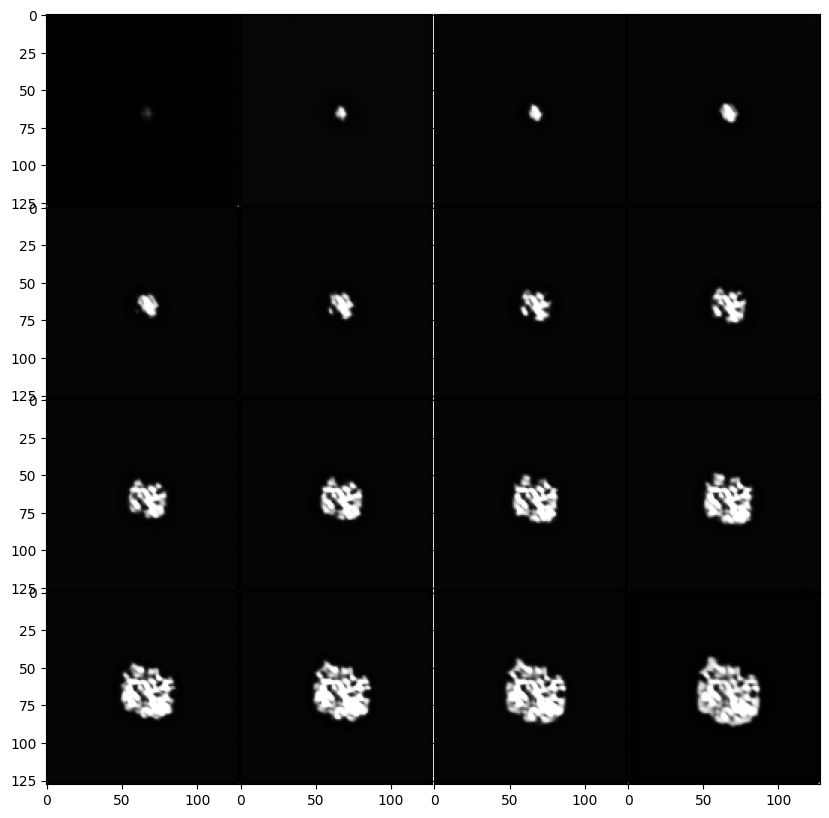

In [116]:
results = torch.squeeze(test_recon,1).cpu().numpy()
print(results.shape)
display_frames(results[4,:,:,:])
# torch.save(cae_model, "trained_cae.pt")
# model = torch.load("trained_cae.pt")
# model.eval()

0 torch.Size([8, 1, 16, 128, 128])
1 torch.Size([8, 131072])
(8, 16, 128, 128)


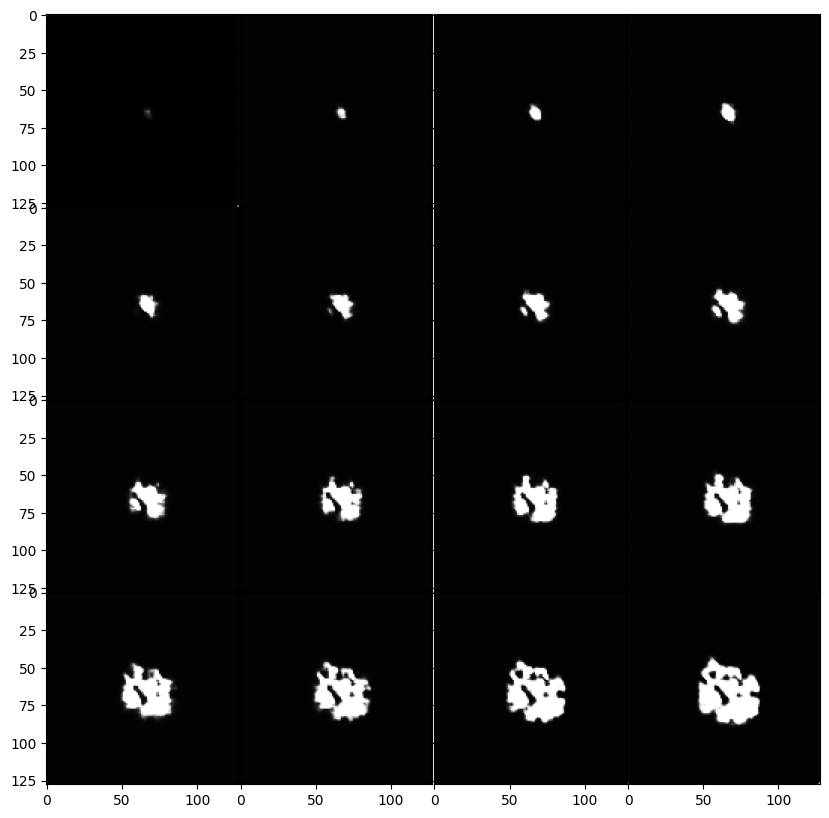

In [109]:
with torch.no_grad():
    meow = model(test_norm_vids)

peak = torch.squeeze(meow,1).cpu().numpy()
print(peak.shape)
display_frames(peak[4,:,:,:])

Use CAE encoder output as input into LSTM to predict sequence to sequence LSTM in reduced space and use decoder to decode results in full space

SyntaxError: incomplete input (445905606.py, line 3)

#### Sources
1. Guo, Xifeng & Liu, Xinwang & Zhu, En & Yin, Jianping. (2017). Deep Clustering with Convolutional Autoencoders. 373-382. 10.1007/978-3-319-70096-0_39. 
